## Task 1.1

In [1]:
import pickle
import networkx as nx
from pathlib import Path

data_path = Path("../data")
pkl_path = data_path / "network_data.pkl"

# 1. Load the previously saved MultiDiGraph G
with open(pkl_path, "rb") as f:
    G = pickle.load(f)

print(G)  # Check the graph type and the number of nodes/edges
print("MultiDiGraph nodes:", G.number_of_nodes())
print("MultiDiGraph edges:", G.number_of_edges())

# 2. Extract retweet / reply edges (account-to-account)
retweet_edges = []
reply_edges = []

for u, v, attrs in G.edges(data=True):
    edge_type = attrs.get("type")
    if edge_type == "retweet":
        retweet_edges.append((u, v, attrs))
    elif edge_type == "reply":
        reply_edges.append((u, v, attrs))

print("Retweet edges:", len(retweet_edges))
print("Reply edges  :", len(reply_edges))


MultiDiGraph with 1936 nodes and 23220 edges
MultiDiGraph nodes: 1936
MultiDiGraph edges: 23220
Retweet edges: 19168
Reply edges  : 4052


In [2]:
# Convert MultiDiGraph → simple undirected graph (for this lab)
# 3. Build a simple undirected graph for retweets
G_rt_nx = nx.Graph()  # Undirected, automatically merges multiple edges
G_rt_nx.add_nodes_from(G.nodes(data=True))  # Copy node attributes as well
# Add only retweet edges (ignore direction, keep a single undirected edge)
for u, v, attrs in retweet_edges:
    G_rt_nx.add_edge(u, v, **attrs)

print("Retweet NX graph:", G_rt_nx.number_of_nodes(), "nodes,", G_rt_nx.number_of_edges(), "edges")

# 4. Build a simple undirected graph for replies
G_rp_nx = nx.Graph()
G_rp_nx.add_nodes_from(G.nodes(data=True))
for u, v, attrs in reply_edges:
    G_rp_nx.add_edge(u, v, **attrs)

print("Reply NX graph  :", G_rp_nx.number_of_nodes(), "nodes,", G_rp_nx.number_of_edges(), "edges")


Retweet NX graph: 1936 nodes, 6325 edges
Reply NX graph  : 1936 nodes, 733 edges


In [3]:
import igraph as ig

def nx_to_igraph_undirected(G_nx: nx.Graph) -> ig.Graph:
    """
    Convert a NetworkX undirected graph into an iGraph graph.
    Preserve node attributes (including author_id, user_type, lang, stance)
    and optionally edge attributes (e.g., retweet_count, like_count, etc.).
    """
    # 1) Ensure each node has a “name” attribute for iGraph
    #    Here we use the node’s own ID (author_id as string) as its name
    nodes = list(G_nx.nodes())
    id_to_idx = {node_id: idx for idx, node_id in enumerate(nodes)}

    # 2) Create an iGraph graph
    g = ig.Graph(n=len(nodes), directed=False)
    g.vs["name"] = [str(n) for n in nodes]

    # 3) Copy node attributes
    # Check which attributes exist on a sample node
    sample_attrs = next(iter(G_nx.nodes(data=True)))[1].keys()
    for attr in sample_attrs:
        g.vs[attr] = [G_nx.nodes[n].get(attr) for n in nodes]

    # 4) Copy edges (and their attributes)
    edges = []
    edge_attrs_dict = {}  # attr_name -> list
    # Identify all edge attribute names from one sample
    sample_edge = next(iter(G_nx.edges(data=True)))[2]
    edge_attr_names = list(sample_edge.keys())

    for u, v, attrs in G_nx.edges(data=True):
        edges.append((id_to_idx[u], id_to_idx[v]))
        for attr in edge_attr_names:
            edge_attrs_dict.setdefault(attr, []).append(attrs.get(attr))

    g.add_edges(edges)
    # Attach all edge attributes
    for attr, values in edge_attrs_dict.items():
        g.es[attr] = values

    return g

# Apply the conversion to retweet / reply graphs
g_rt = nx_to_igraph_undirected(G_rt_nx)
g_rp = nx_to_igraph_undirected(G_rp_nx)

print(g_rt.summary())
print(g_rp.summary())

IGRAPH UN-- 1936 6325 -- 
+ attr: lang (v), name (v), stance (v), user_type (v), like_count (e), quote_count (e), reply_count (e), retweet_count (e), type (e)
IGRAPH UN-- 1936 733 -- 
+ attr: lang (v), name (v), stance (v), user_type (v), like_count (e), quote_count (e), reply_count (e), retweet_count (e), type (e)


1,936 nodes and 6,325 edges

+ attr: lang (v), name (v), stance (v), user_type (v), like_count (e), quote_count (e), reply_count (e), retweet_count (e), type (e)

The nodes have 4 attributes (language, name, stance, user type)

The edges have 5 attributes (interaction counts + type)

In [ ]:
# As suggested in the lab tips: simplify the graph (merge multiple edges and remove self-loops)
# Here multiple=True and loops=True are defaults, so g_rt.simplify() alone is enough
g_rt_simpl = g_rt.simplify()
g_rp_simpl = g_rp.simplify()

print("=== After simplify() ===")
print("Retweet:", g_rt_simpl.summary())
print("Reply  :", g_rp_simpl.summary())

# From here on, use these two simplified graphs for further analysis
g_rt = g_rt_simpl
g_rp = g_rp_simpl

=== After simplify() ===
Retweet: IGRAPH UN-- 1936 6325 -- 
+ attr: lang (v), name (v), stance (v), user_type (v)
Reply  : IGRAPH UN-- 1936 611 -- 
+ attr: lang (v), name (v), stance (v), user_type (v)


## Task 1.2

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def summarize_graph(g: ig.Graph, name="graph", plot_degree_dist=True):
    print(f"=== Summary for {name} ===")
    
    # 1) Basic structure
    n = g.vcount()
    m = g.ecount()
    print(f"Order (nodes): {n}")
    print(f"Size  (edges): {m}")
    
    # 2) Connected components
    comps = g.components()  # or g.clusters()
    num_comps = len(comps)
    largest_comp_size = max(len(c) for c in comps)
    print(f"Number of components: {num_comps}")
    print(f"Largest component size: {largest_comp_size} "
          f"({largest_comp_size/n:.2%} of all nodes)")
    
    # 3) Density
    density = g.density()
    print(f"Density: {density:.6f}")
    
    # 4) Clustering coefficient / transitivity
    transitivity = g.transitivity_undirected()
    print(f"Global clustering (transitivity): {transitivity:.6f}")
    
    # 5) Degree statistics
    degrees = g.degree()
    deg_arr = np.array(degrees)
    print(f"Degree: min={deg_arr.min()}, "
          f"mean={deg_arr.mean():.2f}, "
          f"max={deg_arr.max()}")
    
    # 6) Optional: compute average path length on the largest connected component
    #    Not required for Task 1.2, but useful for understanding — you can keep or comment it out
    try:
        giant = comps.giant()  # Largest connected component subgraph
        avg_path_len = giant.average_path_length()
        print(f"Average path length (giant component): {avg_path_len:.3f}")
    except Exception as e:
        print("Could not compute average path length:", e)
    
    # 7) Degree distribution (log–log plot)
    if plot_degree_dist:
        # Count how many nodes have each degree value
        unique_deg, counts = np.unique(deg_arr, return_counts=True)
        
        # Remove degree-0 nodes (cannot display on log–log scale)
        mask = unique_deg > 0
        unique_deg = unique_deg[mask]
        counts = counts[mask]
        
        # Use frequency (probability) instead of absolute count
        probs = counts / counts.sum()
        
        plt.figure(figsize=(5, 4))
        plt.loglog(unique_deg, probs, marker='o', linestyle='none')
        plt.xlabel("Degree k (log scale)")
        plt.ylabel("P(k) (log scale)")
        plt.title(f"Degree distribution (log-log) - {name}")
        plt.grid(True, which="both", ls="--", alpha=0.3)
        plt.show()
    
    print()  # Blank line for separation

=== Summary for Retweet network ===
Order (nodes): 1936
Size  (edges): 6325
Number of components: 1013
Largest component size: 921 (47.57% of all nodes)
Density: 0.003377
Global clustering (transitivity): 0.115361
Degree: min=0, mean=6.53, max=374
Average path length (giant component): 2.793


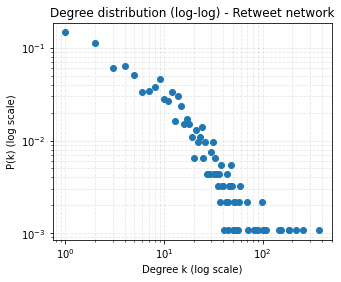


=== Summary for Reply network ===
Order (nodes): 1936
Size  (edges): 611
Number of components: 1544
Largest component size: 378 (19.52% of all nodes)
Density: 0.000326
Global clustering (transitivity): 0.017934
Degree: min=0, mean=0.63, max=88
Average path length (giant component): 3.563


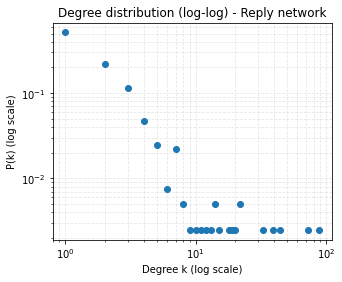

In [6]:
summarize_graph(g_rt, name="Retweet network")
summarize_graph(g_rp, name="Reply network")

## Task 1.3

In [7]:
output_dir = Path("../output")  
output_dir.mkdir(exist_ok=True)

def plot_network(g, layout, name="network", filename=None):
    # Vertex and edge colors
    g.vs["color"] = "steelblue"
    g.es["color"] = "lightgrey"   # Simple color scheme to avoid RGBA compatibility issues

    if filename is None:
        filename = output_dir / f"{name}_nodelink.png"
    else:
        filename = Path(filename)

    print(f"Saving plot to: {filename}")

    # Create matplotlib figure and axes
    fig, ax = plt.subplots(figsize=(8, 8))

    # Key: target=ax → make igraph use the matplotlib backend instead of Cairo
    ig.plot(
        g,
        layout=layout,
        target=ax,
        bbox=(800, 800),
        margin=40,
        vertex_size=3,
        vertex_frame_width=0,
        vertex_label=None,
        edge_width=0.2,
    )

    # Save using matplotlib
    fig.savefig(filename, dpi=150, bbox_inches="tight")
    plt.close(fig)


In [8]:
layout_rt = g_rt.layout_fruchterman_reingold()
layout_rp = g_rp.layout_fruchterman_reingold()

plot_network(g_rt, layout_rt, name="retweet_network")
plot_network(g_rp, layout_rp, name="reply_network")

Saving plot to: ../output/retweet_network_nodelink.png
Saving plot to: ../output/reply_network_nodelink.png


In [24]:
import igraph as ig
import matplotlib.pyplot as plt
from pathlib import Path

output_dir = Path("../output")
output_dir.mkdir(exist_ok=True)

def plot_network(g, layout, name="network", filename=None, vertex_size=3):
    g.vs["color"] = "steelblue"
    g.es["color"] = "lightgrey"

    if filename is None:
        filename = output_dir / f"{name}_nodelink.png"
    else:
        filename = Path(filename)

    print(f"Saving plot to: {filename}")

    fig, ax = plt.subplots(figsize=(8, 8))
    ig.plot(
        g,
        layout=layout,
        target=ax,
        bbox=(800, 800),
        margin=40,
        vertex_size=vertex_size,
        vertex_frame_width=0,
        vertex_label=None,
        edge_width=0.2,
    )
    fig.savefig(filename, dpi=150, bbox_inches="tight")
    plt.close(fig)

# 1) get giant components
giant_rt = g_rt.components().giant()
giant_rp = g_rp.components().giant()

print(giant_rt.summary())
print(giant_rp.summary())

# 2) only compute layout for giant components
layout_rt_giant = giant_rt.layout_fruchterman_reingold()
layout_rp_giant = giant_rp.layout_fruchterman_reingold()

# 3) plot with larger node sizes
plot_network(giant_rt, layout_rt_giant,
             name="retweet_network_giant", vertex_size=4)
plot_network(giant_rp, layout_rp_giant,
             name="reply_network_giant", vertex_size=4)


IGRAPH UN-- 921 6321 -- 
+ attr: color (v), lang (v), name (v), stance (v), user_type (v), color (e)
IGRAPH UN-- 378 596 -- 
+ attr: color (v), lang (v), name (v), stance (v), user_type (v), color (e)
Saving plot to: ../output/retweet_network_giant_nodelink.png
Saving plot to: ../output/reply_network_giant_nodelink.png


## Task 1.4

In [9]:
def degree_to_sizes(g, min_size=3, max_size=20):
    """
    Generate a vertex_size array based on node degrees in the entire graph.
    Use logarithmic scaling to prevent super-hubs from visually flattening other nodes.
    """
    deg = np.array(g.degree())      # Degree of all nodes
    log_deg = np.log1p(deg)         # log(1 + k)

    if log_deg.max() == log_deg.min():
        sizes = np.full_like(log_deg, (min_size + max_size) / 2.0, dtype=float)
    else:
        norm = (log_deg - log_deg.min()) / (log_deg.max() - log_deg.min())
        sizes = min_size + norm * (max_size - min_size)

    return sizes.tolist()

In [26]:
import matplotlib.pyplot as plt
from pathlib import Path
import igraph as ig

output_dir = Path("../output")
output_dir.mkdir(exist_ok=True)

def plot_network_with_sizes(g, layout, sizes, name="network"):
    g.vs["color"] = "steelblue"
    g.es["color"] = "lightgrey"

    filename = output_dir / f"{name}_degree.png"
    print(f"Saving plot to: {filename}")

    fig, ax = plt.subplots(figsize=(8, 8))
    ig.plot(
        g,
        layout=layout,
        target=ax,
        bbox=(800, 800),
        margin=40,
        vertex_size=sizes,        
        vertex_frame_width=0,
        vertex_label=None,
        edge_width=0.2,
    )
    fig.savefig(filename, dpi=150, bbox_inches="tight")
    plt.close(fig)


In [27]:
# 1) get sizes based on degree
sizes_rt = degree_to_sizes(giant_rt, min_size=3, max_size=25)
sizes_rp = degree_to_sizes(giant_rp, min_size=3, max_size=25)

# 2) plot network with sizes
plot_network_with_sizes(giant_rt, layout_rt_giant, sizes_rt,
                        name="retweet_giant_degree")
plot_network_with_sizes(giant_rp, layout_rp_giant, sizes_rp,
                        name="reply_giant_degree")


Saving plot to: ../output/retweet_giant_degree_degree.png
Saving plot to: ../output/reply_giant_degree_degree.png


## Task 1.5

In [11]:
def betweenness_exact(g):
    """
    Compute exact betweenness centrality for all nodes.
    Uses igraph's built-in Brandes algorithm.
    
    Parameters
    ----------
    g : igraph.Graph
        The network graph (undirected, unweighted).
    
    Returns
    -------
    list of float
        Betweenness centrality values for all nodes.
    """
    print("Using EXACT betweenness (igraph Brandes algorithm)...")
    bw = g.betweenness(directed=False, weights=None)
    return bw

In [12]:
import random

def betweenness_approx_sampled(g, nsamples=200, seed=0):
    """
    Approximate betweenness centrality:
    - Randomly select nsamples source nodes
    - Run one iteration of Brandes' single-source algorithm per source
    - Accumulate results and scale by sampling ratio
    Suitable for undirected, unweighted graphs.
    Returns: a list of length g.vcount()
    """
    random.seed(seed)
    n = g.vcount()
    vertices = list(range(n))
    ns = min(nsamples, n)
    sources = random.sample(vertices, ns)

    bw = np.zeros(n, dtype=float)
    neighbors = [g.neighbors(v) for v in range(n)]  # Pre-fetch neighbors to speed up

    for s in sources:
        # Brandes single-source step (unweighted graph)
        S = []                      # Stack
        P = [[] for _ in range(n)]  # Predecessors
        sigma = [0.0] * n           # Number of shortest paths
        sigma[s] = 1.0
        d = [-1] * n                # Distance
        d[s] = 0
        Q = [s]                     # BFS queue

        while Q:
            v = Q.pop(0)
            S.append(v)
            for w in neighbors[v]:
                if d[w] < 0:        # w discovered for the first time
                    Q.append(w)
                    d[w] = d[v] + 1
                if d[w] == d[v] + 1:
                    sigma[w] += sigma[v]
                    P[w].append(v)

        # Dependency back-propagation
        delta = [0.0] * n
        while S:
            w = S.pop()
            for v in P[w]:
                if sigma[w] > 0:
                    delta_v = (sigma[v] / sigma[w]) * (1.0 + delta[w])
                    delta[v] += delta_v
            if w != s:
                bw[w] += delta[w]

    # Scale by sampling ratio (rough correction)
    factor = float(n) / float(ns)
    bw *= factor
    print("Using APPROXIMATE betweenness (sampling)...")
    return bw.tolist()


In [13]:
# Reply
bw_rp = betweenness_exact(g_rp)

# Retweet
bw_rt = betweenness_approx_sampled(g_rt, nsamples=300, seed=42)

Using EXACT betweenness (igraph Brandes algorithm)...
Using APPROXIMATE betweenness (sampling)...


In [14]:
# Validate if the approximation is reasonable on the smaller Reply graph:
bw_rp_exact = betweenness_exact(g_rp)
bw_rp_approx = betweenness_approx_sampled(g_rp, nsamples=300, seed=42)

bw_rp_exact_arr = np.array(bw_rp_exact)
bw_rp_approx_arr = np.array(bw_rp_approx)

corr = np.corrcoef(bw_rp_exact_arr, bw_rp_approx_arr)[0, 1]
print("Correlation between exact & approx on Reply:", corr)

top10_exact  = set(bw_rp_exact_arr.argsort()[-10:])
top10_approx = set(bw_rp_approx_arr.argsort()[-10:])
print("Top-10 overlap:", len(top10_exact & top10_approx), "/ 10")


Using EXACT betweenness (igraph Brandes algorithm)...
Using APPROXIMATE betweenness (sampling)...
Correlation between exact & approx on Reply: 0.9853548980738237
Top-10 overlap: 7 / 10


In [15]:
# Plotting
import numpy as np

def centrality_to_sizes(values, min_size=3, max_size=20):
    """
    Map a centrality array (degree, betweenness, etc.) to a suitable range of node sizes.
    Use logarithmic scaling to avoid distortion from extreme values.
    values: 1D array or list (length = number of nodes)
    """
    vals = np.array(values, dtype=float)
    # Shift negative values (if any) to be >= 0
    vals = vals - vals.min()
    log_vals = np.log1p(vals)  # log(1 + x)

    if log_vals.max() == log_vals.min():
        # Extreme case where all values are identical
        return np.full_like(log_vals, (min_size + max_size) / 2.0, dtype=float).tolist()
    else:
        norm = (log_vals - log_vals.min()) / (log_vals.max() - log_vals.min())
        sizes = min_size + norm * (max_size - min_size)
        return sizes.tolist()

In [16]:
# 1) Map betweenness to node sizes
sizes_rp_bw = centrality_to_sizes(bw_rp, min_size=2, max_size=20)
sizes_rt_bw = centrality_to_sizes(bw_rt, min_size=2, max_size=20)

# 2) Assume you already have layout_rt and layout_rp (computed in Task 1.3)
# layout_rt = g_rt.layout_fruchterman_reingold()
# layout_rp = g_rp.layout_fruchterman_reingold()

def plot_network_with_sizes(g, layout, sizes, name="network", suffix="betweenness"):
    g.vs["color"] = "steelblue"
    g.es["color"] = "lightgrey"

    filename = output_dir / f"{name}_{suffix}.png"
    print(f"Saving plot to: {filename}")

    fig, ax = plt.subplots(figsize=(8, 8))
    ig.plot(
        g,
        layout=layout,
        target=ax,
        bbox=(800, 800),
        margin=40,
        vertex_size=sizes,
        vertex_frame_width=0,
        vertex_label=None,
        edge_width=0.2,
    )
    fig.savefig(filename, dpi=150, bbox_inches="tight")
    plt.close(fig)

# 3) Plot betweenness-based node sizes for all nodes in the full graphs
plot_network_with_sizes(g_rt, layout_rt, sizes_rt_bw,
                        name="retweet_network", suffix="betweenness")
plot_network_with_sizes(g_rp, layout_rp, sizes_rp_bw,
                        name="reply_network", suffix="betweenness")

Saving plot to: ../output/retweet_network_betweenness.png
Saving plot to: ../output/reply_network_betweenness.png


## Task 1.6

In [17]:
import pandas as pd
import numpy as np

# Degree (all nodes)
deg_rt = np.array(g_rt.degree())
deg_rp = np.array(g_rp.degree())

# Betweenness (already computed earlier)
# bw_rt = betweenness_approx_sampled(g_rt, nsamples=300, seed=42)
# bw_rp = betweenness_exact(g_rp)

def get_top_indices(values, n=10):
    """Return the indices of the top-n nodes with highest centrality (descending order)"""
    return np.argsort(values)[-n:][::-1]

top10_deg_rt_idx = get_top_indices(deg_rt)
top10_deg_rp_idx = get_top_indices(deg_rp)
top10_bw_rt_idx  = get_top_indices(bw_rt)
top10_bw_rp_idx  = get_top_indices(bw_rp)

# Retrieve the corresponding actor_id (stored as 'name' in igraph vertex attributes)
top10_deg_rt_ids = [g_rt.vs[i]["name"] for i in top10_deg_rt_idx]
top10_deg_rp_ids = [g_rp.vs[i]["name"] for i in top10_deg_rp_idx]
top10_bw_rt_ids  = [g_rt.vs[i]["name"] for i in top10_bw_rt_idx]
top10_bw_rp_ids  = [g_rp.vs[i]["name"] for i in top10_bw_rp_idx]

print("Top 10 by DEGREE (Retweet):", top10_deg_rt_ids)
print("Top 10 by DEGREE (Reply):  ", top10_deg_rp_ids)
print("Top 10 by BETWEENNESS (Retweet):", top10_bw_rt_ids)
print("Top 10 by BETWEENNESS (Reply):  ", top10_bw_rp_ids)


Top 10 by DEGREE (Retweet): ['17463923', '2617471956', '4010449719', '14159148', '247637778', '389548615', '243236419', '38146999', '3584633117', '21866534']
Top 10 by DEGREE (Reply):   ['2617471956', '389548615', '2381085919', '2365497828', '26207020', '2784989480', '1476593672', '17463923', '243236419', '69032746']
Top 10 by BETWEENNESS (Retweet): ['17463923', '2617471956', '247637778', '4010449719', '14159148', '243236419', '389548615', '2482232082', '69032746', '3584633117']
Top 10 by BETWEENNESS (Reply):   ['2617471956', '389548615', '2381085919', '2365497828', '26207020', '243236419', '2784989480', '69032746', '17463923', '1591198093']


In [18]:
# Load account metadata
accounts_df = pd.read_csv("../data/accounts.tsv", sep="\t", dtype={"author_id": str})


In [19]:
def describe_top_accounts(ids, accounts_df, label):
    df = accounts_df[accounts_df["author_id"].isin(ids)]
    print(f"\n=== {label} ===")
    if df.empty:
        print("None of these top accounts are in the annotated producers list.")
    else:
        print(df[["author_id", "Type", "Lang", "Stance"]])
        print(f"→ {len(df)} / {len(ids)} accounts matched annotated producers")

describe_top_accounts(top10_deg_rt_ids, accounts_df, "Retweet – Top 10 by Degree")
describe_top_accounts(top10_bw_rt_ids,  accounts_df, "Retweet – Top 10 by Betweenness")
describe_top_accounts(top10_deg_rp_ids, accounts_df, "Reply – Top 10 by Degree")
describe_top_accounts(top10_bw_rp_ids,  accounts_df, "Reply – Top 10 by Betweenness")



=== Retweet – Top 10 by Degree ===
       author_id                 Type Lang   Stance
346    243236419  Private individuals   en      For
393     21866534      Advocacy actors   en      For
457   2617471956     Political actors   fr  Unclear
459   4010449719     Political actors   en  Unclear
1250   389548615  Private individuals   en      For
1570  3584633117      Advocacy actors   en      For
1585   247637778  Private individuals   fr      For
1705    17463923      Advocacy actors   en      For
1710    38146999     Political actors   en      For
1750    14159148     Political actors   en      For
→ 10 / 10 accounts matched annotated producers

=== Retweet – Top 10 by Betweenness ===
       author_id                 Type Lang   Stance
7     2482232082     Political actors   es  Unclear
346    243236419  Private individuals   en      For
457   2617471956     Political actors   fr  Unclear
459   4010449719     Political actors   en  Unclear
1250   389548615  Private individuals   en  

## Task 1.7 (Retweet Network)

In [20]:
# Select the retweet network
g = g_rt

# Find all connected components
components = g.components()

print(f"Number of components: {len(components)}")
sizes = [len(c) for c in components]
print(f"Largest component size: {max(sizes)}")

# Extract the largest connected component (giant component)
giant = components.giant()
print(giant.summary())

Number of components: 1013
Largest component size: 921
IGRAPH UN-- 921 6321 -- 
+ attr: color (v), lang (v), name (v), stance (v), user_type (v), color (e)


=== Summary for Retweet network – Largest component ===
Order (nodes): 921
Size  (edges): 6321
Number of components: 1
Largest component size: 921 (100.00% of all nodes)
Density: 0.014920
Global clustering (transitivity): 0.115354
Degree: min=1, mean=13.73, max=374
Average path length (giant component): 2.793


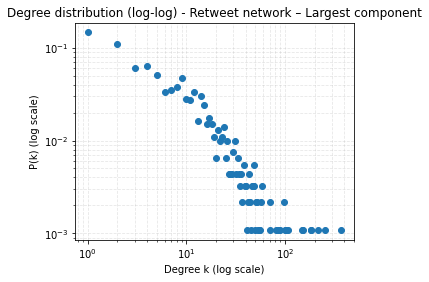

In [21]:
summarize_graph(giant, name="Retweet network – Largest component")

## Task 1.7 (Reply Network)

In [22]:
# Find all connected components
rp_components = g_rp.components()
print("Number of components in reply network:", len(rp_components))

sizes = [len(c) for c in rp_components]
print("Sizes of components (top 10):", sorted(sizes, reverse=True)[:10])
print("Largest component size:", max(sizes))

# Extract the largest connected component (giant component)
giant_rp = rp_components.giant()
print(giant_rp.summary())


Number of components in reply network: 1544
Sizes of components (top 10): [378, 5, 3, 2, 2, 2, 2, 2, 2, 2]
Largest component size: 378
IGRAPH UN-- 378 596 -- 
+ attr: color (v), lang (v), name (v), stance (v), user_type (v), color (e)


=== Summary for Reply network – Largest component ===
Order (nodes): 378
Size  (edges): 596
Number of components: 1
Largest component size: 378 (100.00% of all nodes)
Density: 0.008365
Global clustering (transitivity): 0.017943
Degree: min=1, mean=3.15, max=88
Average path length (giant component): 3.563


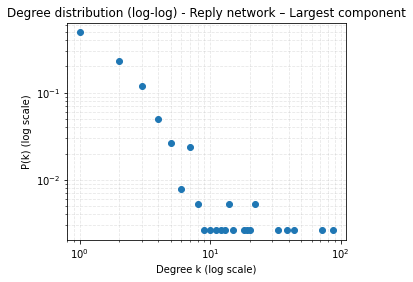

In [23]:
summarize_graph(giant_rp, name="Reply network – Largest component")